Changes from previous version:
-added underscores for private functions
-calculate score/variation/distribution functions: replaced num_labels with num_scales+1 to make it less confusing
-changed name of call_count_scales_and_check_inversion to count_scales, changed name of count_scales to count_scales_helper, changed name of run_count_on_directory to count_scales_directory
-count_scales function:
    -now takes the image filepath as a parameter and does cv2.imread inside the count_scales function
    -added check_invert (auto, orig, or invert) and noise_thresh parameters
    -changed return value to a dictionary to make it cleaner
    -also returns a boolean that is True if the inverted image is selected (needed later for displaying)
    -no longer calls display_results inside the function; instead, it returns the values necessary to display results later
-changed return values for calculate_score and threshold_adaptive to dictionaries as well
-changed display function so that a single function works for both original and inverted cases
-updated split_count_select so that it still works with the other changes

Questions:
 - does dist_dist function and distance_standard_deviation and average_shortest_distances_squared lists do anything? (currently commented out)
 - threshold_otsu function: in the line print('block size from formula'), is there a reason why the last term is not divided by 2, unlike the line following it?
 - should split_count_select have a way to automatically decide how many subimages?
 - decide how to display the final results in .py file

Explanation of split_count_select()
Splits a large image into subimages of equal size (have to give it a number of subimages to split into).
For each subimage:
1. Performs Otsu threshold and uses results to determine blocksize and iterations.
2. Performs adaptive thresholding using selected blocksize and iterations. Removes noise.
3. Calculates a score for the result based on scale size variation and uniformity of distribution. The lower the score, the better.
4. If the score is too high, repeat steps 1-3 on inverted image and see if the score for the inverted image is lower. Keep the one with lower score.

Finally, choose the 3 subimages with the lowest (best) scores (printed in a list at the bottom as SELECTED SUBIMAGES)

Explanation of run_count_on_directory()
Does the same as split_count_select but does not split images and therefore does not choose best subimages.

In [855]:
import cv2
import numpy as np
from datascience import *
import matplotlib as mpl
from matplotlib import pyplot as plt
import sys
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 120
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
#import pandas
import statistics
import image_slicer
from scipy.spatial.distance import pdist as pdist

In [856]:
#def dist_dist(c):
    #dm = pdist(c, 'euclidean')

# add docstring
def _shortest_distance(n, c):
    min_dis = np.inf
    for i in c:
        if (i[0] != n[0] and i[1] != n[1]) and sum((n - i)**2)**.5 < min_dis :
             min_dis = sum((n - i)**2)**.5 
    return min_dis

def _avg_shortest_distance(centroids):
    '''Returns standard deviation and mean of the shortest distances between centroids.'''
    index = 0
    shortest_dis = []
    #iterates through every centroid
    for i in np.arange(0, len(centroids)):
        c = centroids[i]
        #compare given centroid to all other centroids and find distance to closest neighbor
        shortest_dis.append(_shortest_distance(c, centroids))
    return np.std(shortest_dis), np.mean(shortest_dis)

In [857]:
def _threshold_otsu(img):
    '''Thresholds image using Otsu and returns sure foreground of result.
    Parameter img is the array of the original image, returned by cv2.imread and already converted to grayscale.'''
    # Apply blur
    blur = cv2.GaussianBlur(img,(5,5),1)
    # Threshold image using Otsu
    ret, thresh = cv2.threshold(blur,0 , 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Perform opening on thresholded image
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=4)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, .25, 255, 0)
    return sure_fg

In [858]:
def _choose_blocksize_and_iterations(otsu_img):
    '''Selects blocksize and iterations and returns them.
    Parameter otsu_img is the image returned by threshold_otsu.'''
    # Collect stats from image
    binary_map = (otsu_img > 0).astype(np.uint8)
    connectivity = 4
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]

    avg_scale_size = np.average(stats[1:,-1])
    # Calculate "uniformity"
    distance_std, avg_shortest_dis_squared = _avg_shortest_distance(centroids)
    
    ##### Remove these lines?
    #distance_standard_deviations.append(distance_std)
    #dist_dist(centroids)
    #average_shortest_distances_squared.append(avg_shortest_dis_squared)
    #print('Block size from formula:', avg_shortest_dis_squared + np.sqrt(avg_scale_size) + int(.214*np.sqrt(avg_scale_size)))
    ######
    
    # Determine blocksize and iterations
    block_size = int(avg_shortest_dis_squared + np.sqrt(avg_scale_size) + int(.214*np.sqrt(avg_scale_size))/2)
    iterations = 0
    if block_size % 2 == 0: # Blocksize must be an odd number
        block_size = block_size + 1
    if block_size > 85:
        iterations = 1
    else:
        iterations = min(int(block_size/15), 3)
    return block_size, iterations

In [859]:
def _threshold_adaptive(img, blocksize, iterations, noise_thresh=1/7):
    '''Performs adaptive thresholding on img using given blocksize and iterations.
    Parameters:
        -img is the array of the original image, returned by cv2.imread and already converted to grayscale.
        -blocksize (odd integer) to use for adaptive thresholding
        -iterations: number of iterations of opening
        -noise_thresh (float <= 1): noise smaller than this fraction of the average scale area (among the larger half of scales) is removed
    Returns a dictionary containing:
        -sure foreground with noise (for displaying purposes)
        -blurred image
        -noise-removed image with scales labeled
        -scale count'''
    odd_median_blur_value = int(blocksize/2)
    if odd_median_blur_value % 2 == 0:
        odd_median_blur_value = odd_median_blur_value + 1
    cv2.medianBlur(img, odd_median_blur_value)
    if (blocksize > 15):
        blur = cv2.bilateralFilter(img,10,10,200)
    else:
        blur = cv2.GaussianBlur(img,(5,5),0)

    # Perform adaptive thresholding and collect stats from thresholded image
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blocksize, -2)
    binary_map = (thresh > 0).astype(np.uint8)
    connectivity = 4
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    # Calculate average scale size among the largest half of the scales
    scale_sizes = np.copy(stats[1:,-1]) # start from 1 instead of 0 to ignore background, use copy so that stats array doesn't get modified
    scale_sizes.sort() # sort the list of scale sizes from smallest to largest
    avg_scale_size = np.average(scale_sizes[len(scale_sizes) // 2:]) # average size among the largest half of the scales
    
    # Fill in holes that are less than 1/5 the average scale size
    thresh2 = cv2.bitwise_not(thresh)
    contour,hier = cv2.findContours(thresh2,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        if cv2.contourArea(cnt) < avg_scale_size/5:
            thresh2 = cv2.drawContours(thresh2, [cnt], -1, (0,0,0), -1)
    thresh = cv2.bitwise_not(thresh2)

    # Perform opening on resulting image
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = iterations)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 1.5 , 255, 0) 

    # Collect stats from sure_foreground image
    binary_map = (sure_fg > 0).astype(np.uint8)
    connectivity = 4 # can be changed
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    # Calculate average scale size among the largest half of the scales
    scale_sizes = np.copy(stats[1:,-1]) # start from 1 instead of 0 to ignore background, use copy so that stats array doesn't get modified
    scale_sizes.sort() # sort the list of scale sizes from smallest to largest
    avg_scale_size = np.average(scale_sizes[len(scale_sizes) // 2:]) # average size among the largest half of the scales
    
    # Remove noise
    for i in range(num_labels):
        # If a scale is smaller than the fraction noise_thresh of the average among the largest half of the scales
        if stats[i, cv2.CC_STAT_AREA] < (avg_scale_size*noise_thresh):
            noise_left = stats[i, cv2.CC_STAT_LEFT]
            noise_top = stats[i, cv2.CC_STAT_TOP]
            # Go through the bounding box of the noise and find all the pixels that are part of the noise
            for x in range(noise_left, noise_left + stats[i, cv2.CC_STAT_WIDTH]):
                for y in range(noise_top, noise_top + stats[i, cv2.CC_STAT_HEIGHT]):
                    if labels[y][x] == i: # If the pixel is part of the noise
                        labels[y][x] = 0 # Remove the noise by replacing the pixel with the background label
            num_labels -= 1
    # Note: Noise has been removed from labels matrix, but the noise is still in stats/centroids matrices.
    # This is ok because we don't use these outdated stats/centroids matrices again (in later functions, we create updated stats matrices by calling connected components again on the noise-removed image.)
    
    # Label and count
    # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0

    results = {'with_noise':sure_fg, 'blur':blur, 'labeled_img':labeled_img,'count':num_labels - 1} # background doesn't count as a scale
    return results

In [860]:
def _overlay(bw_img, color_mask, w1=0.2, w2=0.95):
    '''Returns image with color_mask overlaid over bw_img.'''
    a = cv2.cvtColor(bw_img, cv2.COLOR_GRAY2RGB)
    a -= np.min(a)
    a = a/np.max(a)*255
    a = np.clip(a, a_min=0, a_max=255).astype(int)
    b = np.clip(color_mask, a_min=0, a_max=255).astype(int)
    c = cv2.addWeighted(b,w1,a,w2,0)
    return c

In [861]:
def display_results(img_name, results, inverted=False):
    '''Displays original image, inverted image (if applicable), blurred image, thresholded image with noise,
    noise-removed image with scales labeled, and overlaid image.
    Parameters:
        -img_name: filepath for original image
        -results: dictionary containing blurred, thresholded, labeled images
        -inverted (boolean): True if inverted image was used, False otherwise
        '''
    orig_img = cv2.imread(img_name)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    print("Image Name: " + img_name)
    count = results['count']
    print("Final Scale Count: " + str(count))
    images = [orig_img, results['blur'], results['with_noise'], results['labeled_img']]
    titles = ['Original Grayscale', 'Blurred Image', 'With Noise', 'Noise-Removed']
    if inverted:
        images.insert(1, _invert(orig_img))
        titles.insert(1, 'Inverted')
    n = len(titles)
    for i in range(n):
        plt.subplot(1,n+1,i+1), plt.imshow(images[i], 'gray')
        plt.title(titles[i], fontsize=5)
        plt.tight_layout()
    
    # display overlaid image
    plt.subplot(1,n+1,n+1), plt.imshow(_overlay(orig_img, results['labeled_img']))
    plt.title('Overlay, Count = ' + str(count), fontsize=5)
    plt.tight_layout()
    plt.show()

In [862]:
def _calculate_score(img):
    '''Calculates and returns score based on average scale size variation and uniformity of scale distribution.
    THE LOWER THE SCORE, THE BETTER.
    Parameter img is the labeled image, returned by threshold_adaptive'''
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary_map = (img > 0).astype(np.uint8) # black pixels are 0 and everything else is 1
    
    # Collect new data on connected components (rather than using previous stats array) because the noise-removal method in _threshold_adaptive changed the image but not the stats array
    output = cv2.connectedComponentsWithStats(binary_map, 4, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    num_scales = num_labels - 1 # background doesn't count as scale
    if num_scales <= 2: # Checks only work if there's more than 2 scales
        return {'score':100, 'size_var':None, 'dist':None} # Return high value to show that result is not good if less than 3 scales
    
    size_var = _scale_size_variation(num_scales, stats, len(img), len(img[0]))
    dist = _distribution(num_scales, centroids) 
    score = (size_var + dist) / 2 # score is the average of size variation and distribution
    return {'score':score, 'size_var':size_var, 'dist':dist}

    
def _bounding_box_edges(i, stats):
    '''Returns coordinates of edges of the bounding box at index i in stats array'''
    left = stats[i, cv2.CC_STAT_LEFT]
    right = left + stats[i, cv2.CC_STAT_WIDTH] - 1
    top = stats[i, cv2.CC_STAT_TOP]
    bottom = top + stats[i, cv2.CC_STAT_HEIGHT] - 1
    return left, right, top, bottom
        
def _scale_size_variation(num_scales, stats, img_len, img_width):
    '''Returns average variation in scale size, calculated without edge scales (except in the case where there are not enough non-edge scales).
    High variation likely corresponds to poor quality results.
    Result is considered very good if return value is less than 1.
    Only works if there is at least 2 scales.'''
    assert num_scales >= 2, "Image must have at least 2 scales."
    scale_areas = []
    edge_scale_areas = []
    for i in range(1, num_scales + 1):
        left, right, top, bottom = _bounding_box_edges(i, stats)
        # don't consider scales that touch the edge
        if left == 0 or top == 0 or right == img_width - 1 or bottom == img_len - 1:
            edge_scale_areas.append(stats[i, cv2.CC_STAT_AREA].astype(int))
            continue
        scale_areas.append(stats[i, cv2.CC_STAT_AREA].astype(int))
    # if 1 or zero non-edge scales, then use edge scales in calculation (otherwise, do not use edge scales)
    if len(scale_areas) < 2:
        scale_areas = scale_areas + edge_scale_areas
    stddev = statistics.stdev(scale_areas)
    mean = sum(scale_areas) / len(scale_areas)
    # if any of the edge scales are more than five times the average size of the non-edge scales, result is bad
    for edge_scale_area in edge_scale_areas:
        if edge_scale_area > 5*mean:
            return 100 # Return high value because result is bad
    return (stddev / mean)

def _distribution(num_scales, centroids):
    '''Calculates and returns the standard deviation of the distances between the centroids of neighboring scales.
    The lower the return value, the more uniform the distribution of scales.
    Only works if there is at least 3 scales (2 distances to compare)'''
    assert num_scales >= 3, "Image must have at least 3 scales."
    x_values = []
    y_values = []
    for i in range(1, num_scales + 1):
        x_values.append(centroids[i, 0])
        y_values.append(centroids[i, 1])
    x_values.sort()
    y_values.sort()
    x_diff = []
    y_diff = []
    for i in range(1, len(x_values)):
        x_diff.append(x_values[i] - x_values[i-1]) # differences between neighboring x-coordinates
        y_diff.append(y_values[i] - y_values[i-1]) # differences between neighboring y-coordinates
    x_stddev = statistics.stdev(x_diff)
    y_stddev = statistics.stdev(y_diff)
    avg_stddev = (x_stddev + y_stddev) / 2
    return avg_stddev

In [863]:
def _compare_results(score_list, num_to_keep):
    '''Compares the scores from different thresholding attempts and returns a list of the indices corresponding to the best one(s).
    Parameters:
        -score_list is a list of scores for each image from calculate_score
        -num_to_keep is the number of images that we want to keep.'''
    best_indices = []
    for i in range(len(score_list)):
        if len(best_indices) < num_to_keep:
            best_indices.append(i)
        else:
            current_worst_score = max([score_list[i] for i in best_indices])
            if score_list[i] < current_worst_score: # if the score is better than the previous scores
                best_indices.remove(score_list.index(current_worst_score)) # remove the index corresponding to lowest score
                best_indices.append(i)
    # if any of the selected images have poor quality, say so
    for i in best_indices:
        if score_list[i] > 5: # if the score is too high (can change this value)
            print("Could not find " + str(num_to_keep) + " subimages that pass the quality check.")
    return best_indices

In [864]:
def _invert(img):
    '''Inverts a grayscale image.'''
    return cv2.bitwise_not(img)

In [865]:
def _count_scales_helper(img, noise_thresh):
    '''Helper function for count_scales. Calls threshold_otsu, then choose_blocksize_and_iterations, then threshold_adaptive.
    Parameters:
        -img is the array of the original image, returned by cv2.imread and already converted to grayscale.
        -noise_thresh (float <= 1): noise smaller than this fraction of the average scale area (among the larger half of scales) is removed
    Returns:
        -results: a list of resulting images
        -data: a dictionary containing blocksize and iterations.'''
    img_otsu = _threshold_otsu(img)
    blocksize, iterations = _choose_blocksize_and_iterations(img_otsu)
    data = {'blocksize':blocksize, 'iterations':iterations}
    results = _threshold_adaptive(img, blocksize, iterations, noise_thresh)
    return results, data

In [866]:
def count_scales(img_name, check_invert='auto', noise_thresh=1/7):
    '''Main function. Counts scales on original image, checks result, and counts scales on inverted image if needed.
    Finally, compares results from original vs. inverted image and returns better results.
    Parameters:
        -img_name is the filepath of the image to be analyzed.
        -check_invert can have values 'auto', 'orig', or 'invert'.
            'auto': count both original and inverted images; select better result
            'orig': count original image only
            'invert': count inverted image only
        -noise_thresh (float <= 1): noise smaller than this fraction of the average scale area (among the larger half of scales) is removed
    Returns:
        -a dictionary containing the resulting images (blurred, thresholded, labeled, etc.) from whichever image was better (original or inverted)
        -a dictionary containing blocksize, iterations, score, size_var, and distribution from whichever image was better (original or inverted)
        -a boolean that is True if inverted image is selected, False otherwise
    '''
    assert check_invert == 'auto' or check_invert == 'orig' or check_invert == 'invert', "check_invert must be 'auto', 'orig', or 'invert'"
    orig_img = cv2.imread(img_name)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2GRAY)
    
    if check_invert == 'orig' or check_invert == 'auto':
        # count scales on original image
        orig_results, orig_data = _count_scales_helper(orig_img, noise_thresh)
        # check how good the results are
        orig_scores = _calculate_score(orig_results['labeled_img'])
        orig_data.update(orig_scores)
        print('Original image data: ' + str(orig_data))
        # If on original mode, or on auto mode and the result is good, display results and finish
        if check_invert == 'orig' or orig_data['score'] < 3:
            print("\nOriginal image passed all tests; did not need to check inverted.")
            return orig_results, orig_data, False
    
    # Try inverted image and compare results to original
    inverted_img = _invert(orig_img)
    # count scales on inverted image
    inverted_results, inverted_data = _count_scales_helper(inverted_img, noise_thresh)
    # check how good the new results are
    inverted_scores = _calculate_score(inverted_results['labeled_img'])
    inverted_data.update(inverted_scores)
    print('Inverted image data: ' + str(inverted_data))
    
    # If on invert mode, display results and finish
    if check_invert == 'invert':
        return inverted_results, inverted_data, True
    
    # Otherwise, compare the results from original and inverted images
    else:
        score_list = [orig_data['score'], inverted_data['score']]
        best_index = _compare_results(score_list, 1)[0]
        if best_index == 0:
            print("\nTried both original and inverted, but decided to keep original.")
            return orig_results, orig_data, False
        elif best_index == 1:
            print("\nDECIDED TO USE INVERTED IMAGE.")
            return inverted_results, inverted_data, True

In [867]:
def count_scales_directory(dirname):
    '''Calls count_scales function on every image in the given directory and displays results.'''
    directory = os.scandir(dirname)
    for img in directory:
        # REMOVE THIS LINE LATER
        if (img.name == '.ipynb_checkpoints' or img.name == '.DS_Store'):
            continue
        results, data, inverted = count_scales(dirname + img.name)
        display_results(dirname + img.name, results, inverted)
    # RETURN THE RESULTS IN A TABLE??

In [892]:
def split_count_select(img_path, num_subimages, num_to_keep):
    '''Splits given image into subimages, counts scales in each subimage, and selects best ones to keep. Displays results.
    Parameters:
        -img_path: filepath for original image
        -num_subimages: number of subimages to split the image into
        -num_to_keep: number of subimages to keep'''
    img = cv2.imread(img_path)
    img_size = img.shape
    tiles = image_slicer.slice(img_path, num_subimages)
    all_scores = []
    all_counts = []
    all_labeled = []
    i = 0
    for tile in tiles:
        print('SUBIMAGE #' + str(i) + ':\n')
        results, data, inverted = count_scales(tile.filename)
        display_results(tile.filename, results, inverted)
        all_scores.append(data['score'])
        all_counts.append(results['count'])
        all_labeled.append(results['labeled_img'])
        i += 1
    best_indices_lst = _compare_results(all_scores, num_to_keep)
    
    estimated_total = _estimate_total_counts(all_counts, best_indices_lst, num_subimages)
    print('ESTIMATED TOTAL COUNT:', estimated_total, "SCALES")
    print('\n_______________________________________________')
    print('\nSELECTED SUBIMAGES: ' + str(best_indices_lst))
    
    
    for i in np.arange(num_to_keep):
        plt.subplot(1,num_to_keep,i+1), plt.imshow(all_labeled[best_indices_lst[i]], 'gray')
        plt.title("Chosen Image: " + str(best_indices_lst[i]), fontsize=5)
    plt.show()

In [887]:
def _estimate_total_counts(all_counts, best_indices, sub_img):
    return (sum([all_counts[i] for i in best_indices]) * sub_img / len(best_indices))    

Original image data: {'blocksize': 57, 'iterations': 3, 'score': 4.174662087279363, 'size_var': 0.5498608283012767, 'dist': 7.799463346257449}
Inverted image data: {'blocksize': 115, 'iterations': 1, 'score': 58.45813385511029, 'size_var': 100, 'dist': 16.916267710220584}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117716Ventral-NoFlash-3.png
Final Scale Count: 31


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


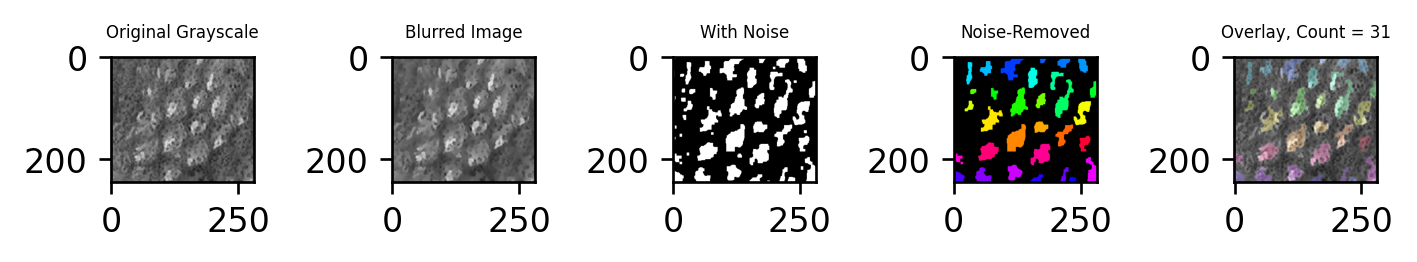

Original image data: {'blocksize': 111, 'iterations': 1, 'score': 5.669456323250853, 'size_var': 0.322842501123643, 'dist': 11.016070145378063}
Inverted image data: {'blocksize': 175, 'iterations': 1, 'score': 100, 'size_var': None, 'dist': None}
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/135185Ventral-NoFlash-3.png
Final Scale Count: 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


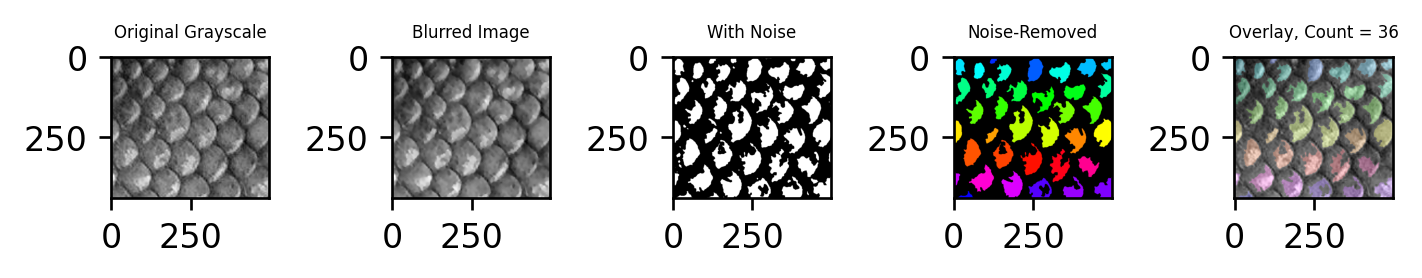

Original image data: {'blocksize': 129, 'iterations': 1, 'score': 5.584807359283438, 'size_var': 0.5900934950288321, 'dist': 10.579521223538045}
Inverted image data: {'blocksize': 85, 'iterations': 3, 'score': 58.6079654035223, 'size_var': 100, 'dist': 17.215930807044597}
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/135185Ventral-NoFlash-2.png
Final Scale Count: 23


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


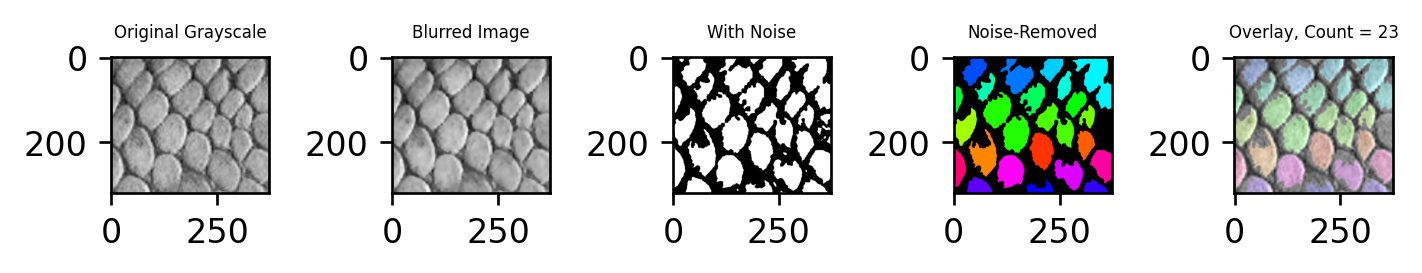

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 35, 'iterations': 2, 'score': 1.2992581886846244, 'size_var': 0.48012480535067775, 'dist': 2.118391572018571}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/117704Dorsal-NoFlash-2.png
Final Scale Count: 143


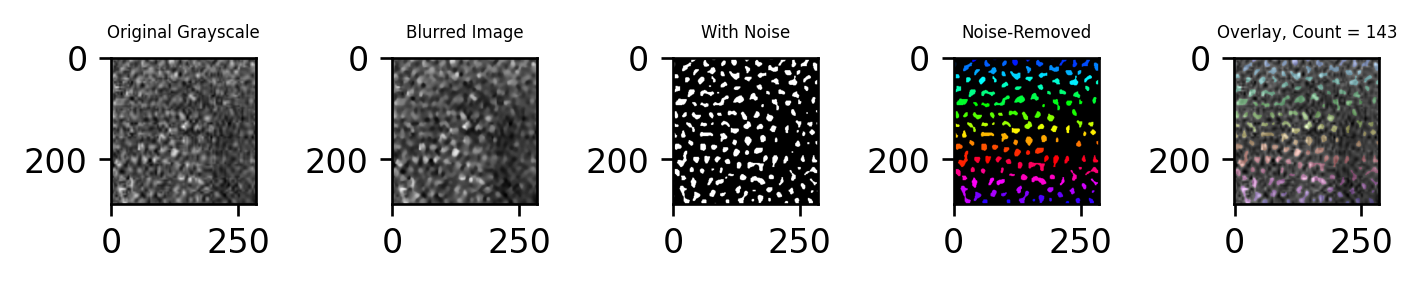

Original image data: {'blocksize': 69, 'iterations': 3, 'score': 3.4526058517915392, 'size_var': 0.6538931380258397, 'dist': 6.251318565557239}
Inverted image data: {'blocksize': 469, 'iterations': 1, 'score': 72.60145516826239, 'size_var': 100, 'dist': 45.202910336524766}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117716Ventral-NoFlash-2.png
Final Scale Count: 62


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


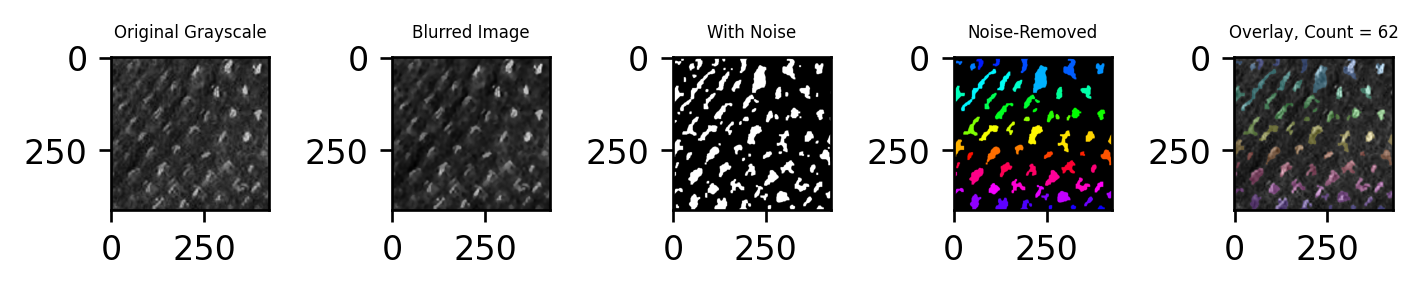

Original image data: {'blocksize': 113, 'iterations': 1, 'score': 4.423035306759637, 'size_var': 0.353460748597705, 'dist': 8.492609864921569}
Inverted image data: {'blocksize': 77, 'iterations': 3, 'score': 33.34893365374521, 'size_var': 1.5336405857110773, 'dist': 65.16422672177934}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/135185Ventral-NoFlash-1.png
Final Scale Count: 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


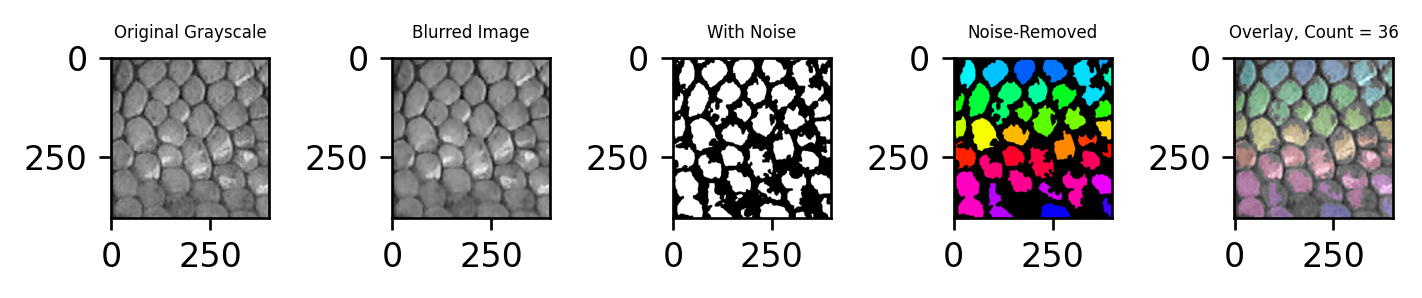

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 43, 'iterations': 2, 'score': 2.0091109097702256, 'size_var': 0.6077767101482241, 'dist': 3.410445109392227}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/117704Dorsal-NoFlash-1.png
Final Scale Count: 60


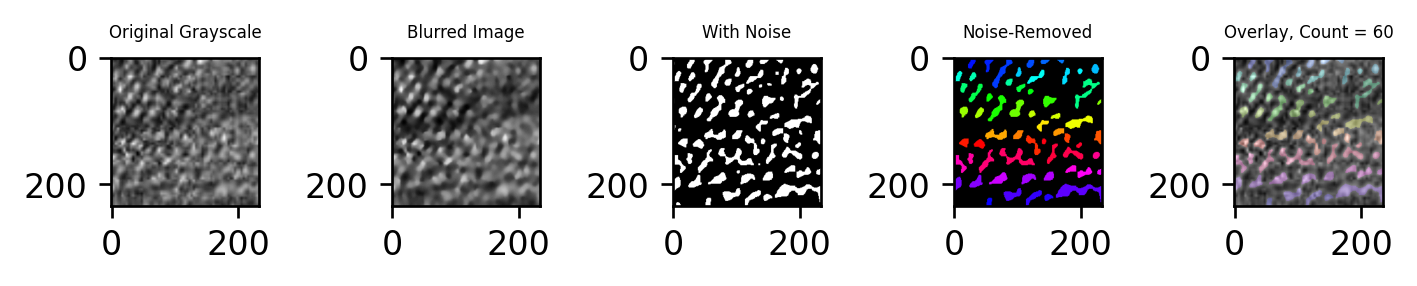

Original image data: {'blocksize': 77, 'iterations': 3, 'score': 3.4712670406723736, 'size_var': 0.9150068931065354, 'dist': 6.027527188238212}
Inverted image data: {'blocksize': 143, 'iterations': 1, 'score': 74.38146197935028, 'size_var': 100, 'dist': 48.762923958700554}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117716Ventral-NoFlash-1.png
Final Scale Count: 78


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


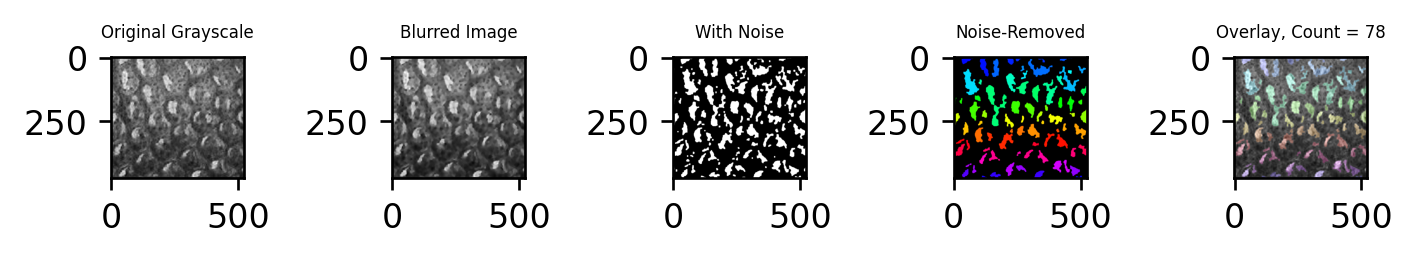

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 49, 'iterations': 3, 'score': 1.793141164762704, 'size_var': 0.40847719347960104, 'dist': 3.177805136045807}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135193Dorsal-NoFlash-3.png
Final Scale Count: 80


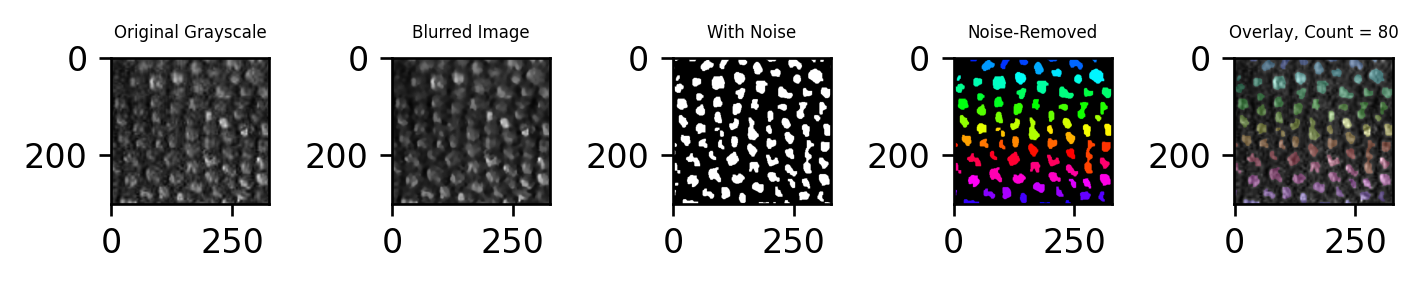

Original image data: {'blocksize': 41, 'iterations': 2, 'score': 1.25976356791949, 'size_var': 0.510298151664845, 'dist': 2.009228984174135}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/117718Dorsal-NoFlash-3.png
Final Scale Count: 88


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


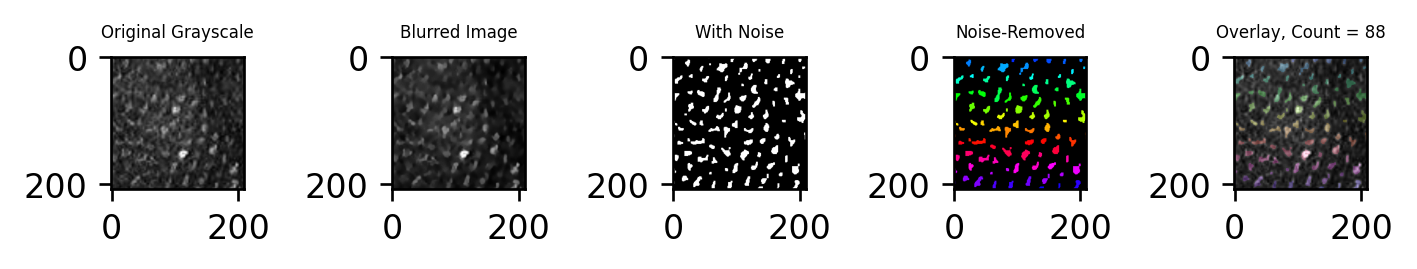

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 41, 'iterations': 2, 'score': 2.0691897015179075, 'size_var': 0.7140971532848593, 'dist': 3.4242822497509557}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/117716Ventral-NoFlash-5.png
Final Scale Count: 60


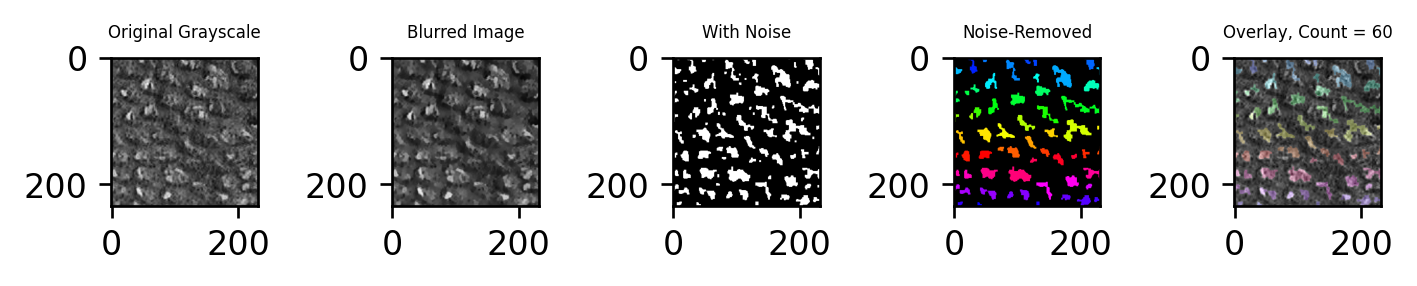

Original image data: {'blocksize': 59, 'iterations': 3, 'score': 3.498171433307169, 'size_var': 0.9338030687777579, 'dist': 6.06253979783658}
Inverted image data: {'blocksize': 57, 'iterations': 3, 'score': 2.406147369116896, 'size_var': 0.6573883159772567, 'dist': 4.154906422256535}

DECIDED TO USE INVERTED IMAGE.
Image Name: Guanica_County_images/117702Dorsal-NoFlash-1.png
Final Scale Count: 50


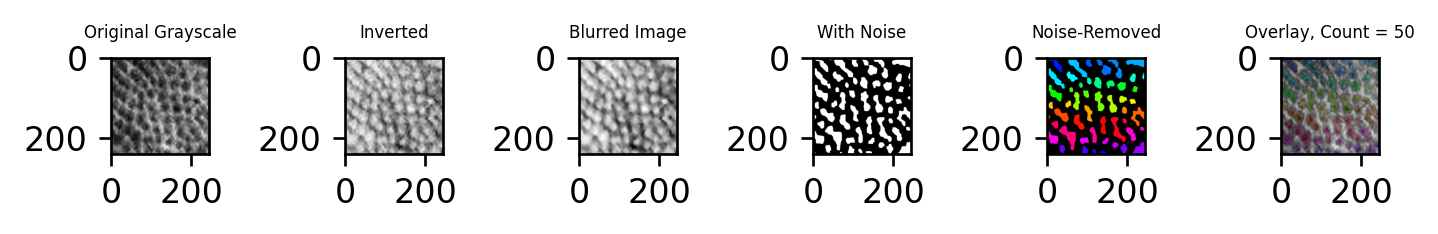

Original image data: {'blocksize': 55, 'iterations': 3, 'score': 3.401934945327612, 'size_var': 0.7503091129078353, 'dist': 6.053560777747388}
Inverted image data: {'blocksize': 171, 'iterations': 1, 'score': 59.73322099107331, 'size_var': 100, 'dist': 19.466441982146613}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117704Ventral-NoFlash-1.png
Final Scale Count: 41


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


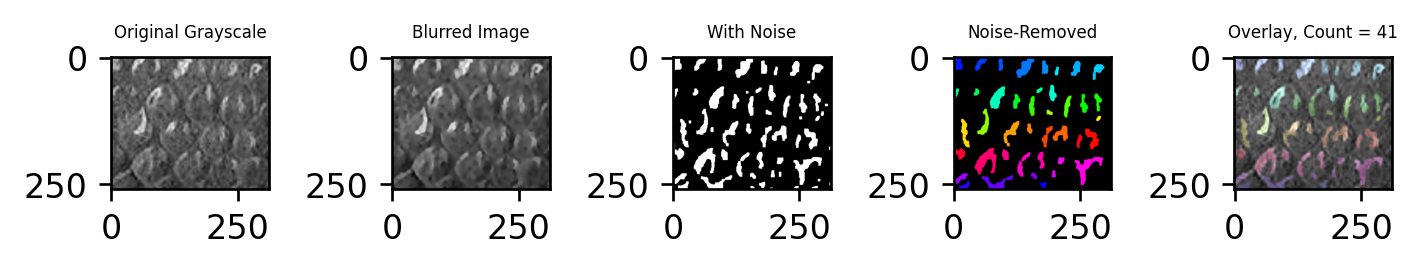

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 67, 'iterations': 3, 'score': 3.277177677844729, 'size_var': 0.5672296930528967, 'dist': 5.9871256626365605}
Inverted image data: {'blocksize': 127, 'iterations': 1, 'score': 56.43547987084616, 'size_var': 100, 'dist': 12.870959741692317}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117716Ventral-NoFlash-4.png
Final Scale Count: 33


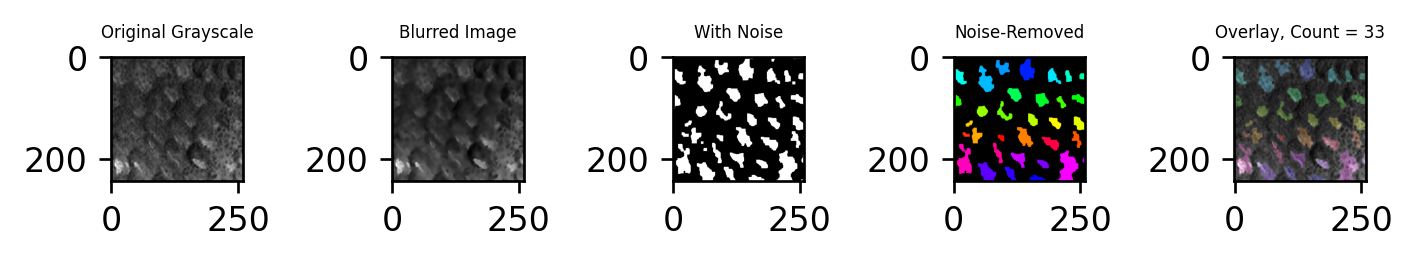

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 41, 'iterations': 2, 'score': 50.93115615512582, 'size_var': 100, 'dist': 1.862312310251642}
Inverted image data: {'blocksize': 55, 'iterations': 3, 'score': 52.20937829501413, 'size_var': 100, 'dist': 4.418756590028265}
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117718Dorsal-NoFlash-2.png
Final Scale Count: 113


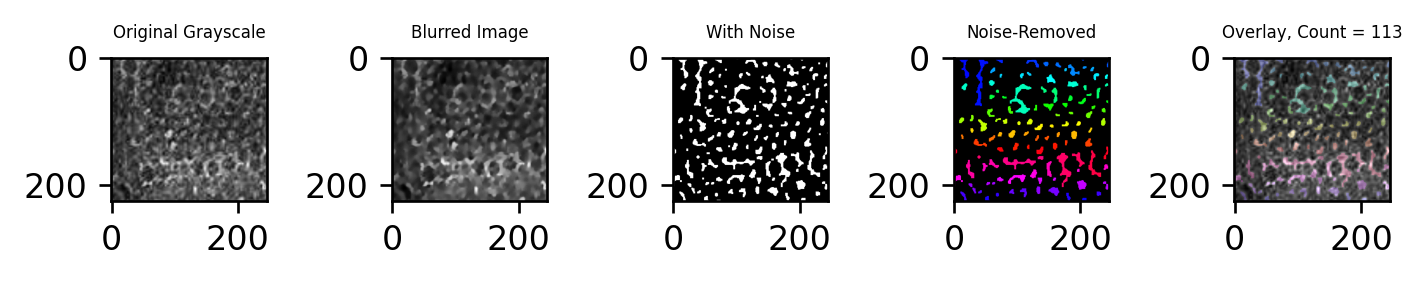

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 47, 'iterations': 3, 'score': 2.001427137772693, 'size_var': 0.5522399467859025, 'dist': 3.4506143287594835}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135193Dorsal-NoFlash-2.png
Final Scale Count: 74


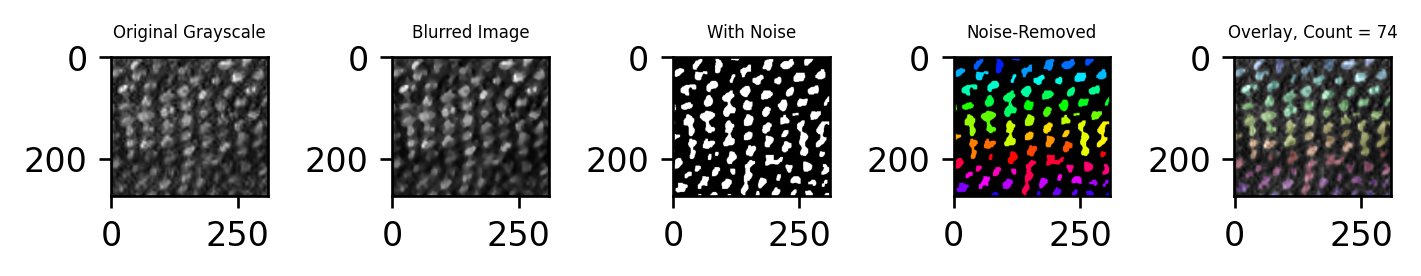

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 55, 'iterations': 3, 'score': 2.3868976477152457, 'size_var': 0.6193549976635261, 'dist': 4.154440297766965}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/117716Ventral-NoFlash-6.png
Final Scale Count: 45


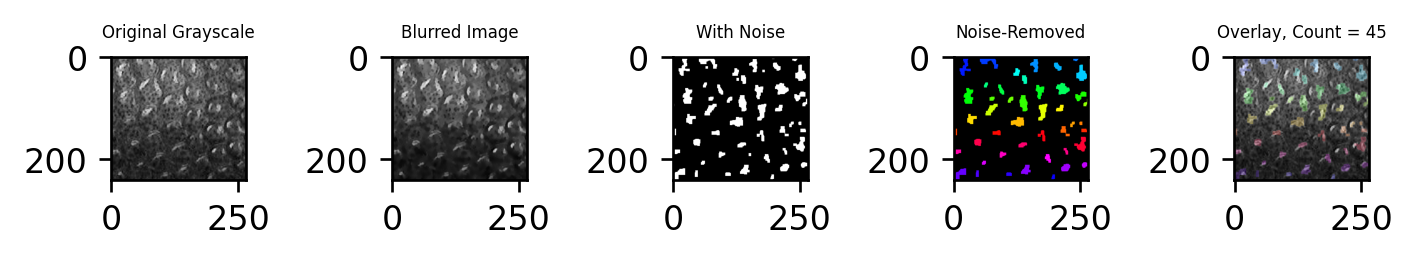

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 39, 'iterations': 2, 'score': 2.4105771242419554, 'size_var': 0.42370514203578724, 'dist': 4.397449106448123}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/117704Ventral-NoFlash-2.png
Final Scale Count: 33


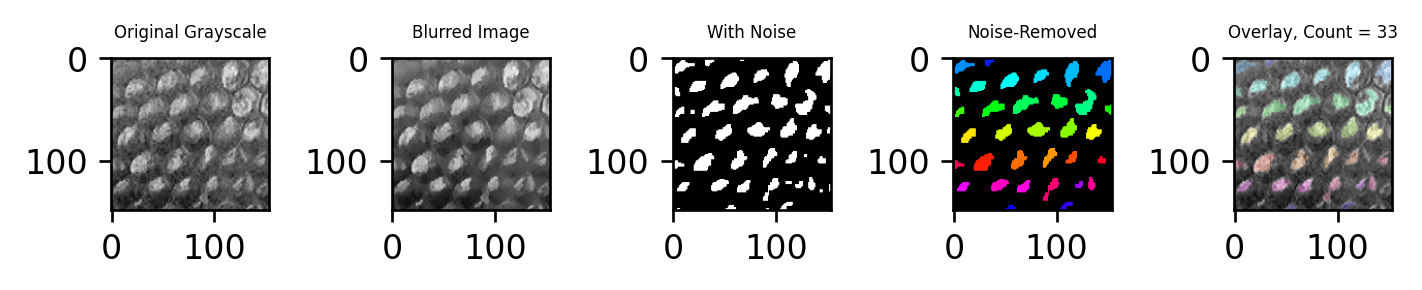

Original image data: {'blocksize': 45, 'iterations': 3, 'score': 52.2649588937325, 'size_var': 100, 'dist': 4.529917787464996}
Inverted image data: {'blocksize': 63, 'iterations': 3, 'score': 53.411547071501396, 'size_var': 100, 'dist': 6.823094143002795}
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117702Dorsal-NoFlash-2.png
Final Scale Count: 52


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


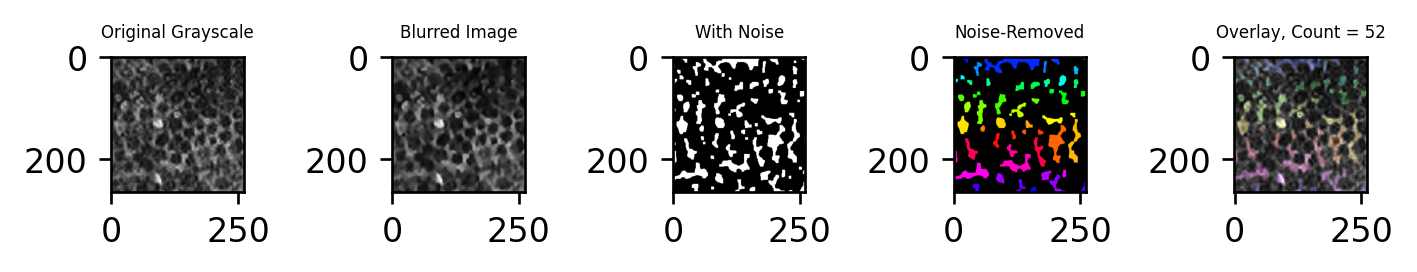

Original image data: {'blocksize': 43, 'iterations': 2, 'score': 1.2078396881638804, 'size_var': 0.86609126256731, 'dist': 1.5495881137604508}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/117718Dorsal-NoFlash-1.png
Final Scale Count: 173


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


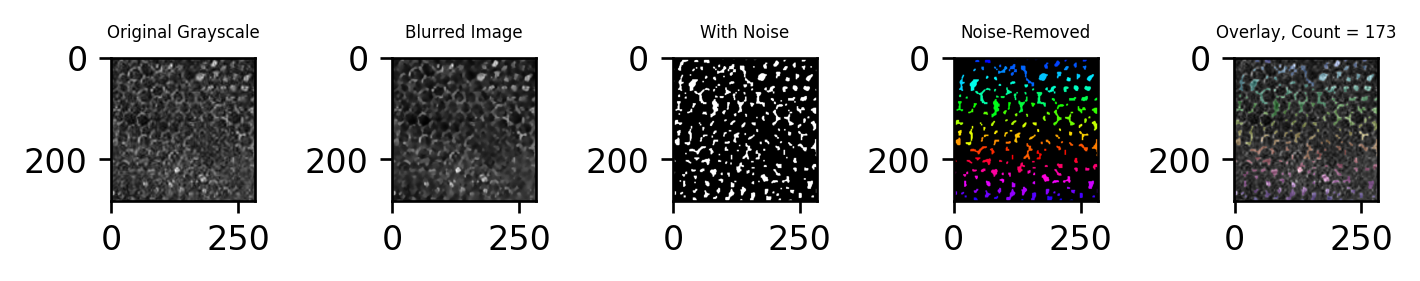

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 49, 'iterations': 3, 'score': 1.9871252164583952, 'size_var': 0.5015363482977272, 'dist': 3.472714084619063}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135193Dorsal-NoFlash-1.png
Final Scale Count: 79


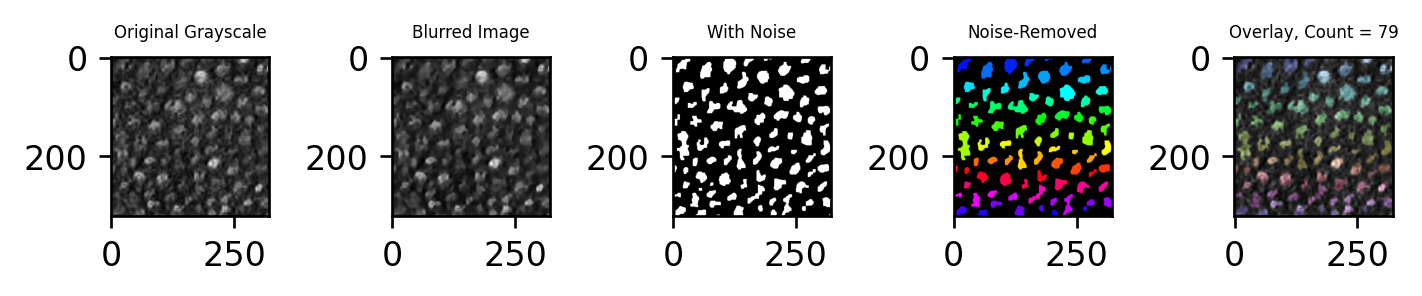

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 41, 'iterations': 2, 'score': 1.4991564195286249, 'size_var': 0.6963489304341054, 'dist': 2.3019639086231445}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135185Dorsal-NoFlash-2.png
Final Scale Count: 106


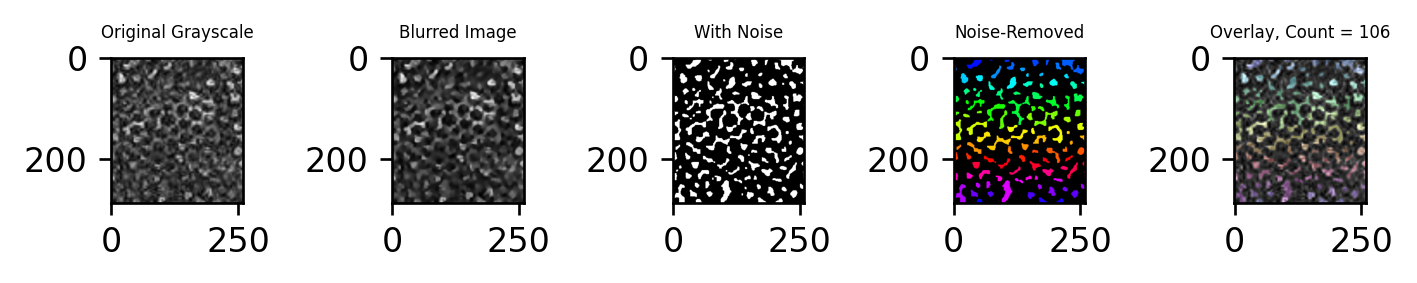

Original image data: {'blocksize': 59, 'iterations': 3, 'score': 3.818372652898603, 'size_var': 0.543352323034817, 'dist': 7.0933929827623885}
Inverted image data: {'blocksize': 131, 'iterations': 1, 'score': 27.027783134245027, 'size_var': 1.6089457764446458, 'dist': 52.44662049204541}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117718Ventral-NoFlash-2.png
Final Scale Count: 40


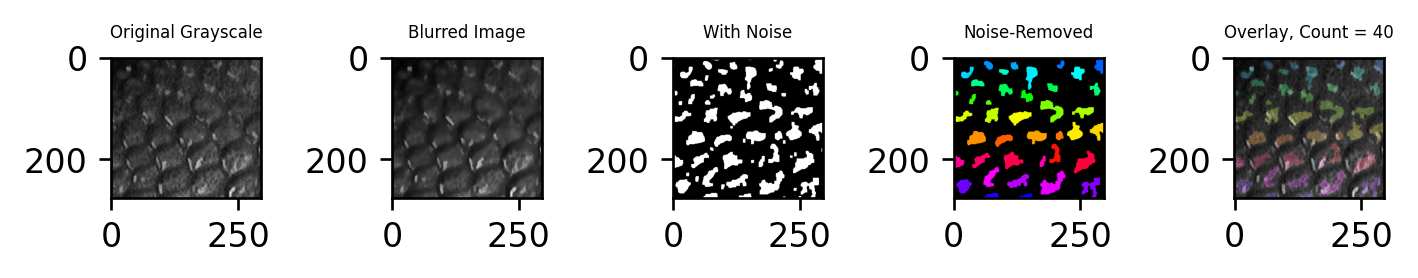

Original image data: {'blocksize': 51, 'iterations': 3, 'score': 2.3509331908773987, 'size_var': 0.7411017848597269, 'dist': 3.9607645968950704}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/117718Ventral-NoFlash-3.png
Final Scale Count: 61


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


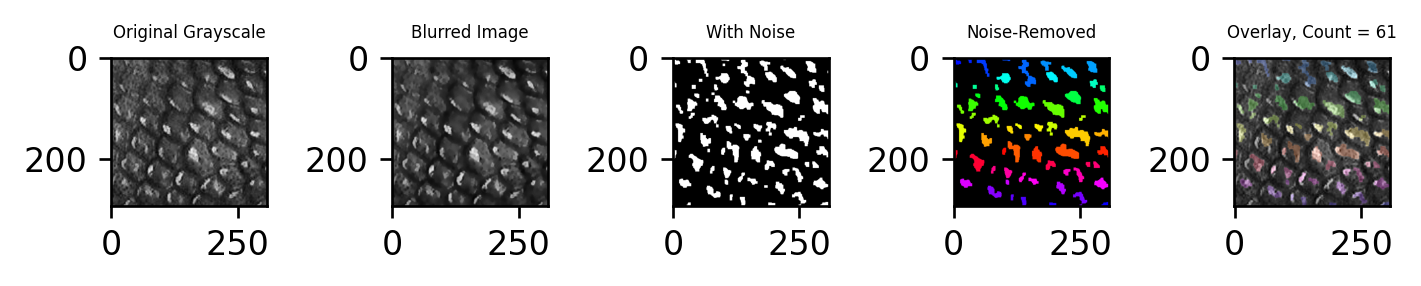

Original image data: {'blocksize': 65, 'iterations': 3, 'score': 2.709107908828039, 'size_var': 0.5153188507428068, 'dist': 4.902896966913271}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135193Ventral-NoFlash-4.png
Final Scale Count: 34


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


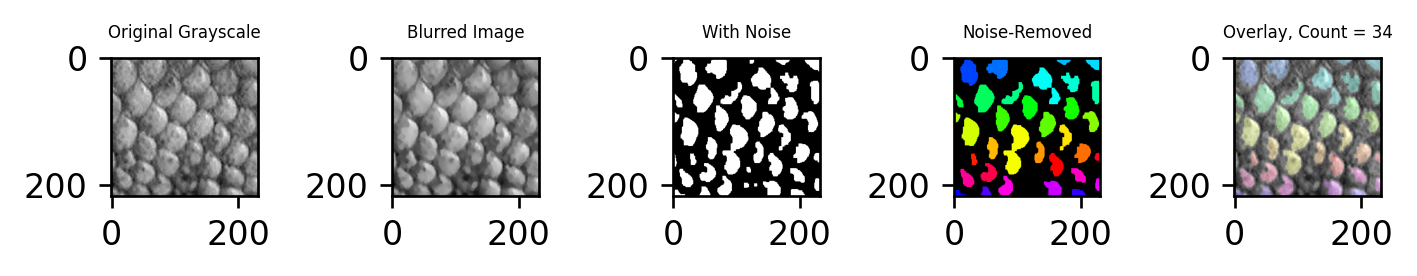

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 41, 'iterations': 2, 'score': 1.33541430966609, 'size_var': 0.6801152404368623, 'dist': 1.9907133788953177}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/117716Dorsal-NoFlash-2.png
Final Scale Count: 152


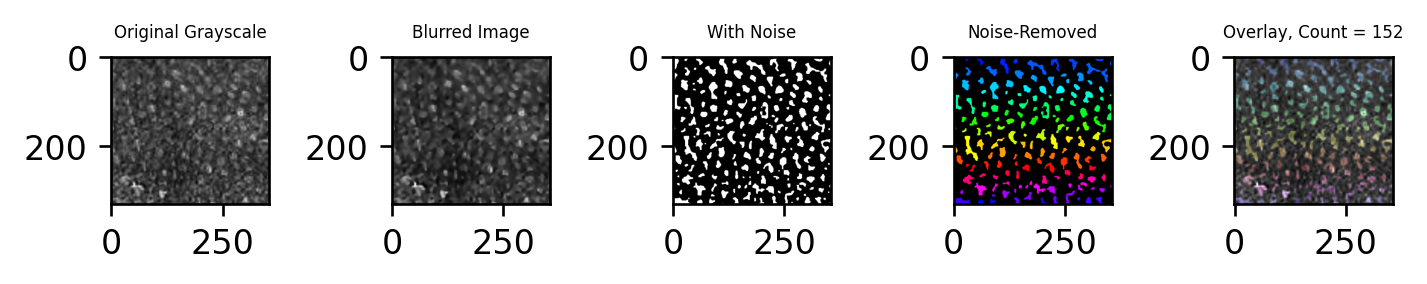

Original image data: {'blocksize': 39, 'iterations': 2, 'score': 53.073720010183834, 'size_var': 100, 'dist': 6.147440020367666}
Inverted image data: {'blocksize': 61, 'iterations': 3, 'score': 52.43050071839079, 'size_var': 100, 'dist': 4.8610014367815735}
Could not find 1 subimages that pass the quality check.

DECIDED TO USE INVERTED IMAGE.
Image Name: Guanica_County_images/135185Dorsal-NoFlash-1.png
Final Scale Count: 64


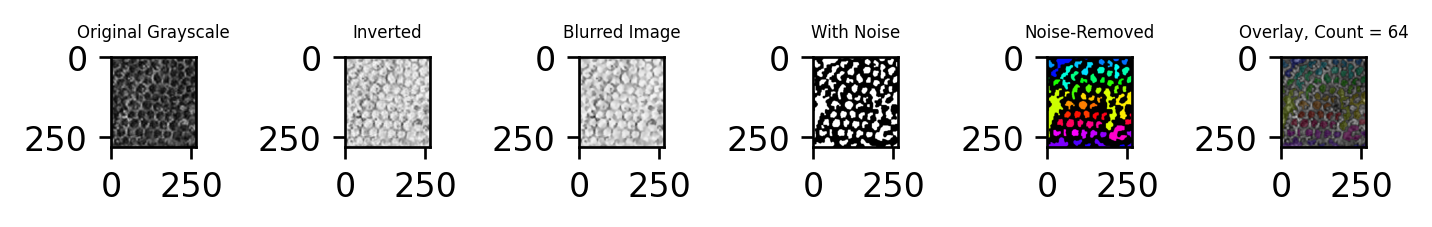

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 73, 'iterations': 3, 'score': 3.854550963424673, 'size_var': 0.7255987406700789, 'dist': 6.983503186179267}
Inverted image data: {'blocksize': 109, 'iterations': 1, 'score': 64.55144093687849, 'size_var': 100, 'dist': 29.102881873756996}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117718Ventral-NoFlash-1.png
Final Scale Count: 39


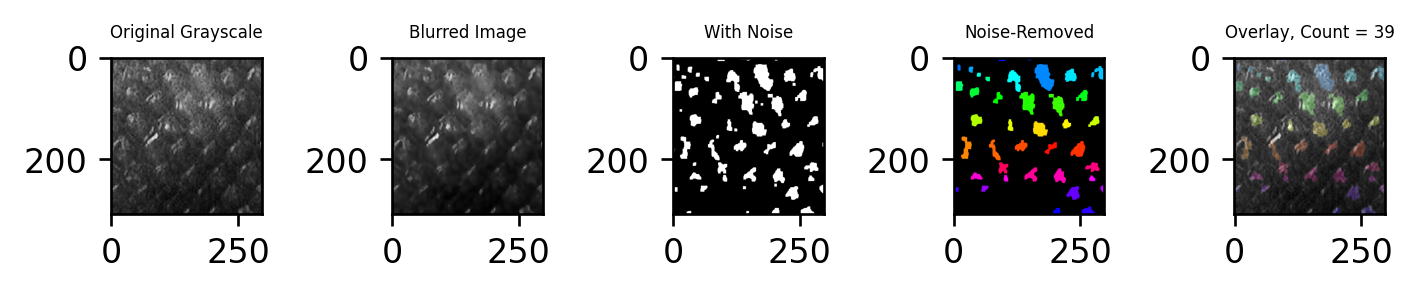

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 47, 'iterations': 3, 'score': 1.3894605203741957, 'size_var': 0.6058189733428231, 'dist': 2.1731020674055683}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/117716Dorsal-NoFlash-1.png
Final Scale Count: 133


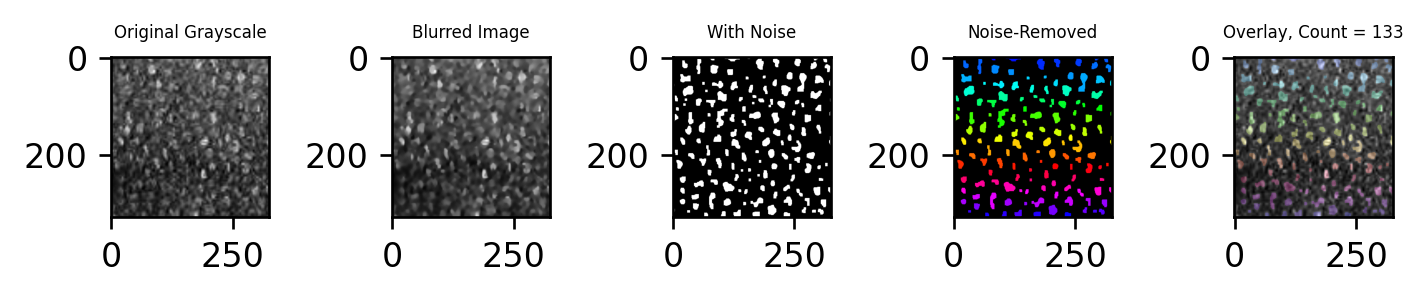

Original image data: {'blocksize': 41, 'iterations': 2, 'score': 1.276267944679168, 'size_var': 0.5983989801805759, 'dist': 1.9541369091777603}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135182Dorsal-NoFlash-1.png
Final Scale Count: 138


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


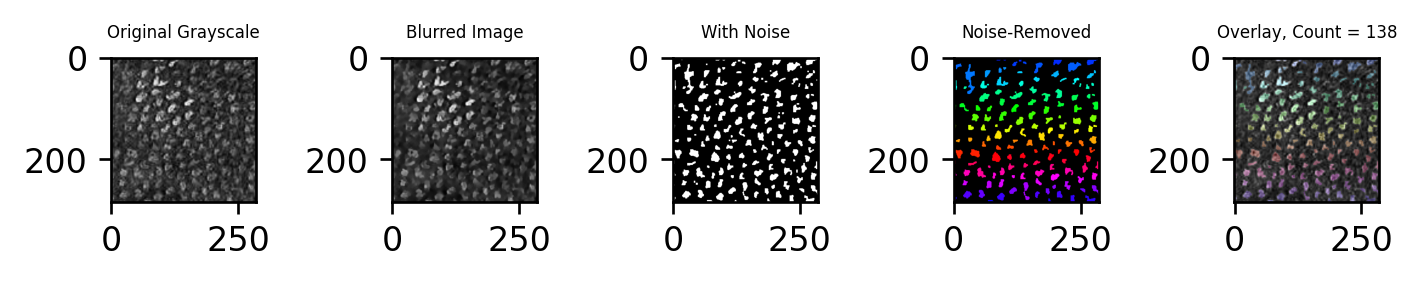

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 71, 'iterations': 3, 'score': 3.4201417131953824, 'size_var': 0.49780822285305726, 'dist': 6.342475203537708}
Inverted image data: {'blocksize': 81, 'iterations': 3, 'score': 100, 'size_var': None, 'dist': None}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/135193Ventral-NoFlash-3.png
Final Scale Count: 42


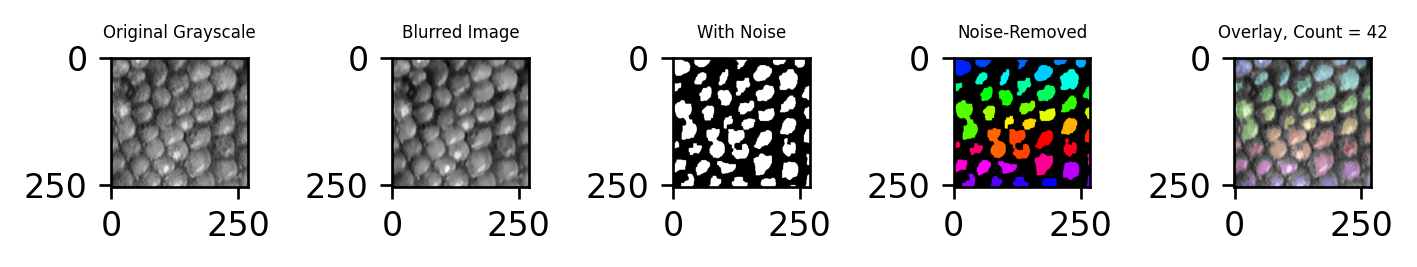

Original image data: {'blocksize': 45, 'iterations': 3, 'score': 2.2066113449881284, 'size_var': 0.47701592968932977, 'dist': 3.936206760286927}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135196Ventral-NoFlash-2.png
Final Scale Count: 45


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


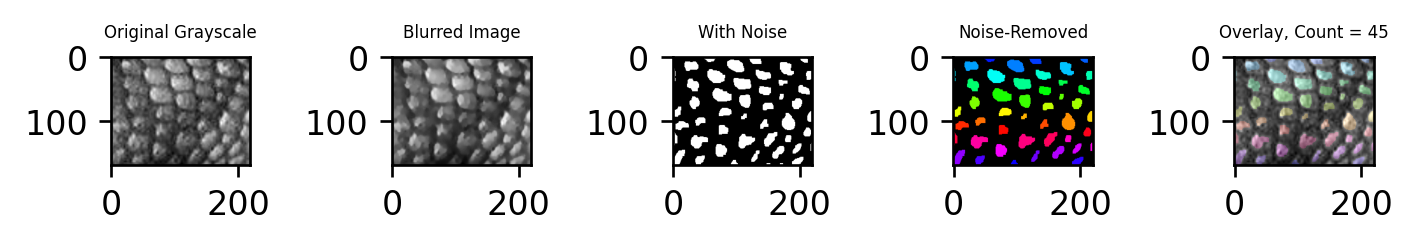

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 71, 'iterations': 3, 'score': 2.897806993691193, 'size_var': 0.4208140166537477, 'dist': 5.374799970728638}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135196Ventral-NoFlash-3.png
Final Scale Count: 46


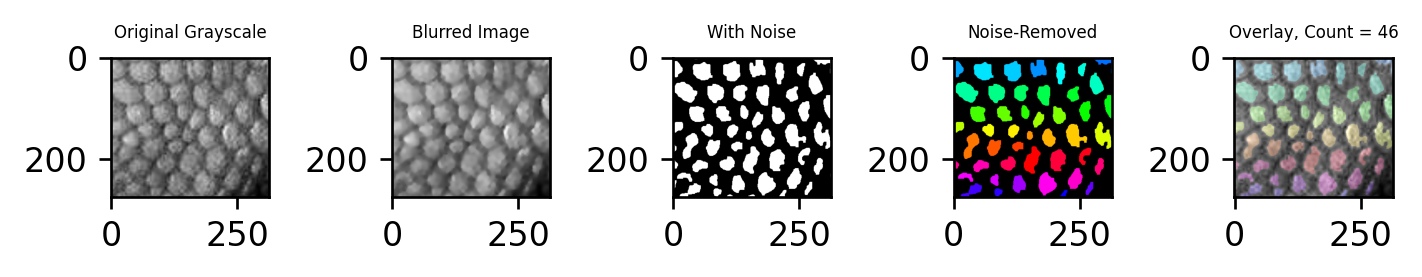

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 57, 'iterations': 3, 'score': 3.154858576683613, 'size_var': 0.3254061374608042, 'dist': 5.984311015906421}
Inverted image data: {'blocksize': 57, 'iterations': 3, 'score': 56.21141269874668, 'size_var': 100, 'dist': 12.42282539749335}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/135193Ventral-NoFlash-2.png
Final Scale Count: 33


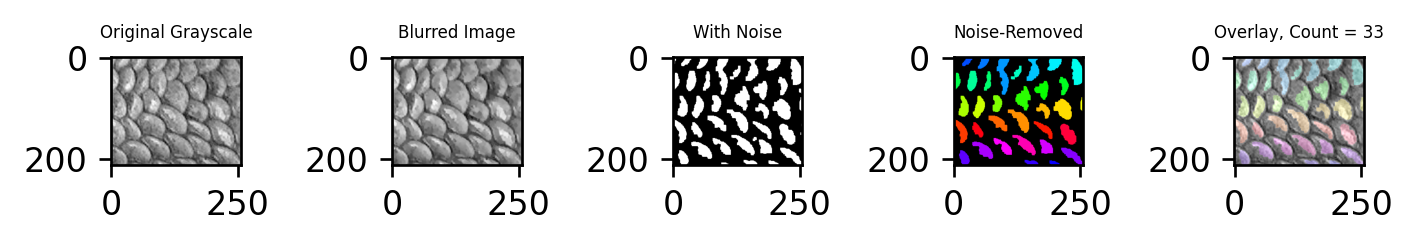

Original image data: {'blocksize': 35, 'iterations': 2, 'score': 1.0303551169676686, 'size_var': 0.46897631522582983, 'dist': 1.5917339187095072}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135182Dorsal-NoFlash-2.png
Final Scale Count: 141


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


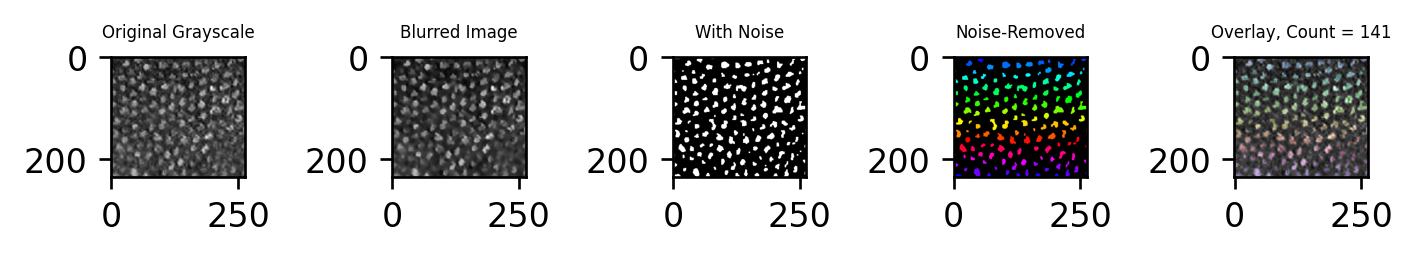

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 61, 'iterations': 3, 'score': 2.6233023486452534, 'size_var': 0.37968657321496835, 'dist': 4.866918124075538}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135196Ventral-NoFlash-1.png
Final Scale Count: 56


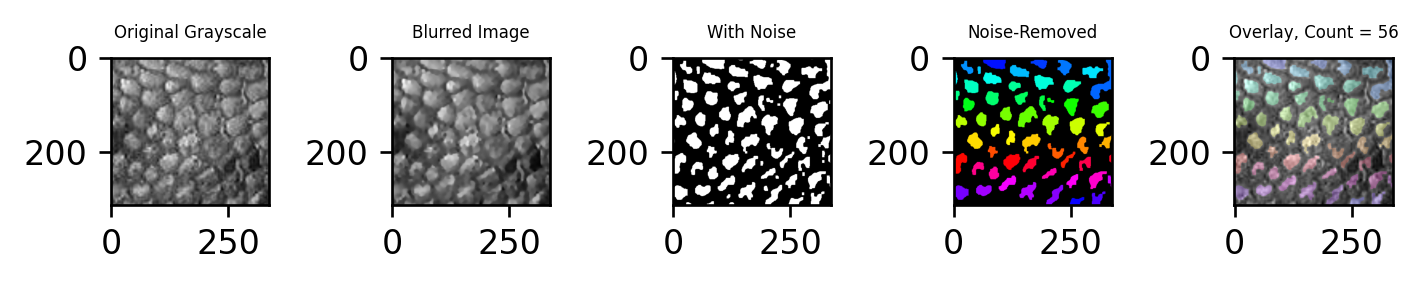

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 41, 'iterations': 2, 'score': 1.5058202176627433, 'size_var': 0.5696900521088955, 'dist': 2.441950383216591}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135182Dorsal-NoFlash-3.png
Final Scale Count: 78


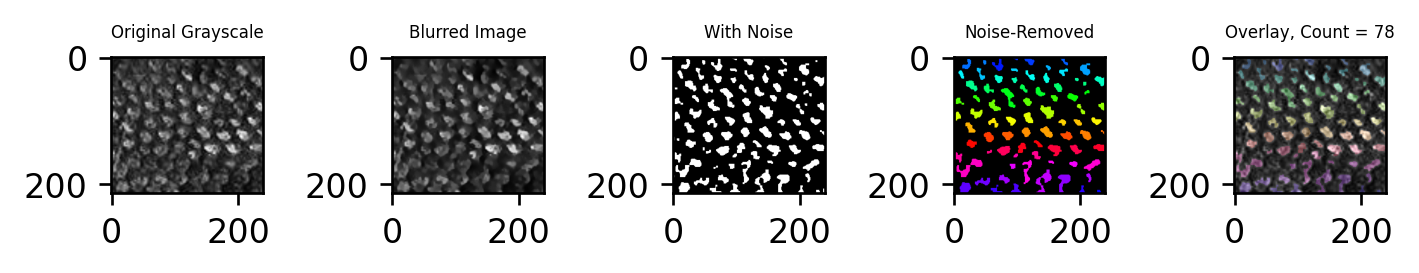

Original image data: {'blocksize': 69, 'iterations': 3, 'score': 3.255936052961462, 'size_var': 0.3939375821826997, 'dist': 6.1179345237402245}
Inverted image data: {'blocksize': 57, 'iterations': 3, 'score': 56.45760600068227, 'size_var': 100, 'dist': 12.915212001364536}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/135193Ventral-NoFlash-1.png
Final Scale Count: 44


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


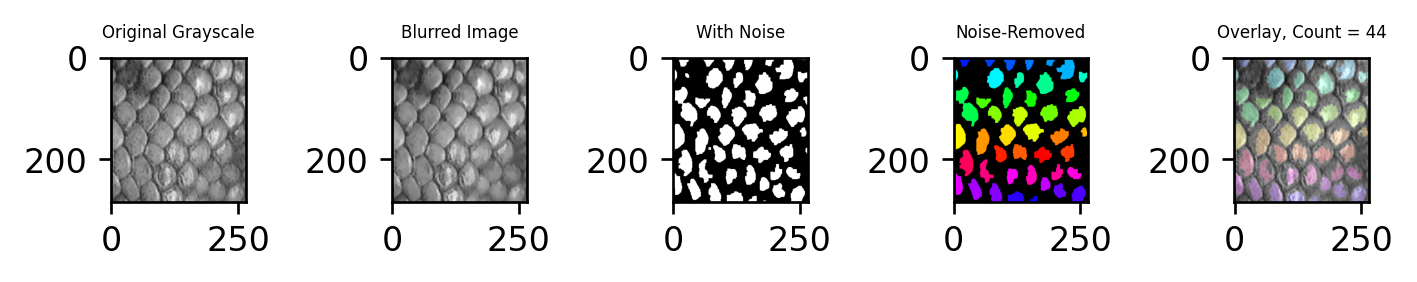

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 51, 'iterations': 3, 'score': 2.9471641470821344, 'size_var': 0.3299695280792862, 'dist': 5.5643587660849825}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135182Ventral-NoFlash-3.png
Final Scale Count: 30


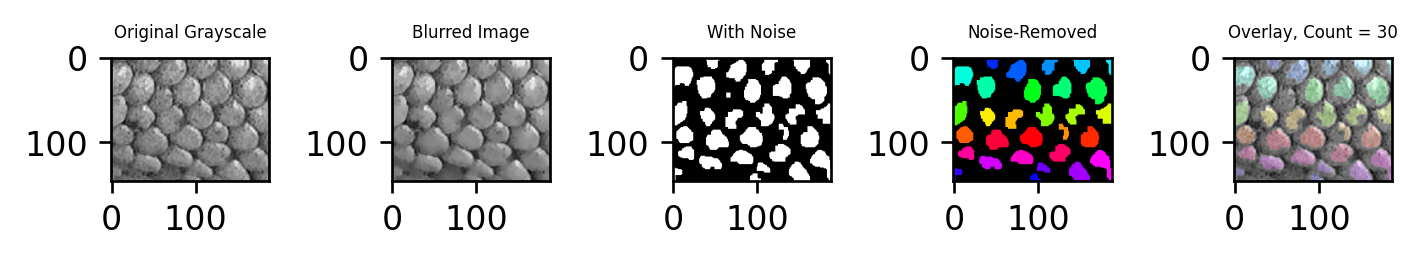

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original image data: {'blocksize': 57, 'iterations': 3, 'score': 1.8364980024647486, 'size_var': 0.30273449539465247, 'dist': 3.3702615095348447}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135182Ventral-NoFlash-2.png
Final Scale Count: 38


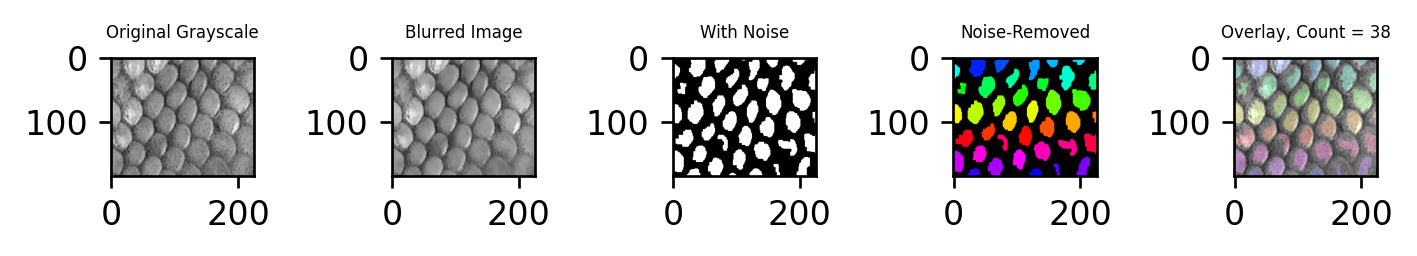

Original image data: {'blocksize': 55, 'iterations': 3, 'score': 2.2179310852075997, 'size_var': 0.4443672208484536, 'dist': 3.9914949495667456}

Original image passed all tests; did not need to check inverted.
Image Name: Guanica_County_images/135182Ventral-NoFlash-1.png
Final Scale Count: 36


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


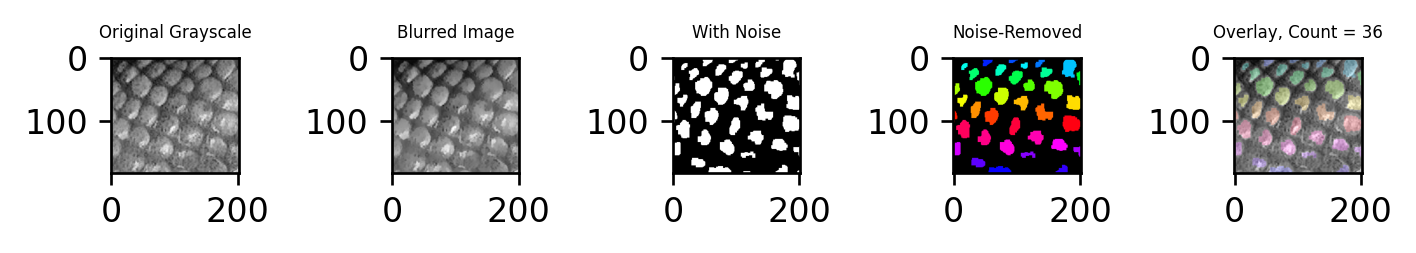

Original image data: {'blocksize': 77, 'iterations': 3, 'score': 4.3275753254769995, 'size_var': 0.3566126479375343, 'dist': 8.298538003016464}
Inverted image data: {'blocksize': 263, 'iterations': 1, 'score': 33.031491265288984, 'size_var': 1.3722119134905908, 'dist': 64.69077061708738}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117702Ventral-NoFlash-2.png
Final Scale Count: 29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


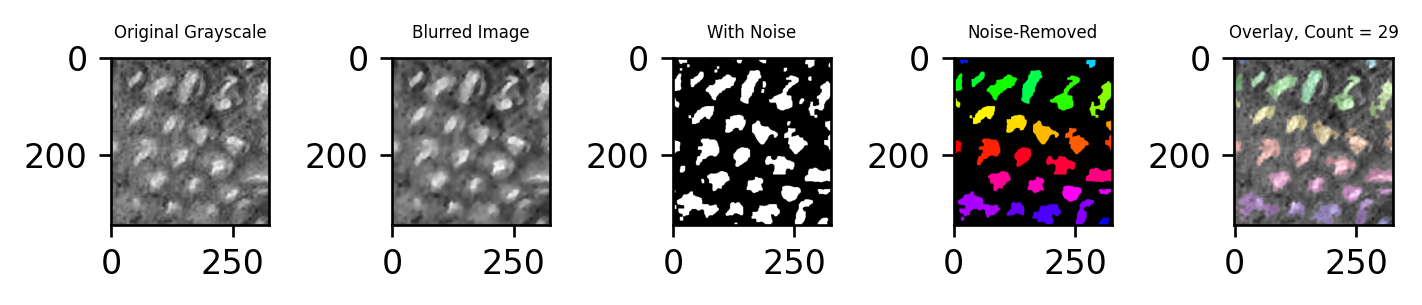

Original image data: {'blocksize': 159, 'iterations': 1, 'score': 100, 'size_var': None, 'dist': None}
Inverted image data: {'blocksize': 87, 'iterations': 1, 'score': 54.923743373577246, 'size_var': 100, 'dist': 9.847486747154495}
Could not find 1 subimages that pass the quality check.

DECIDED TO USE INVERTED IMAGE.
Image Name: Guanica_County_images/117702Ventral-NoFlash-3.png
Final Scale Count: 23


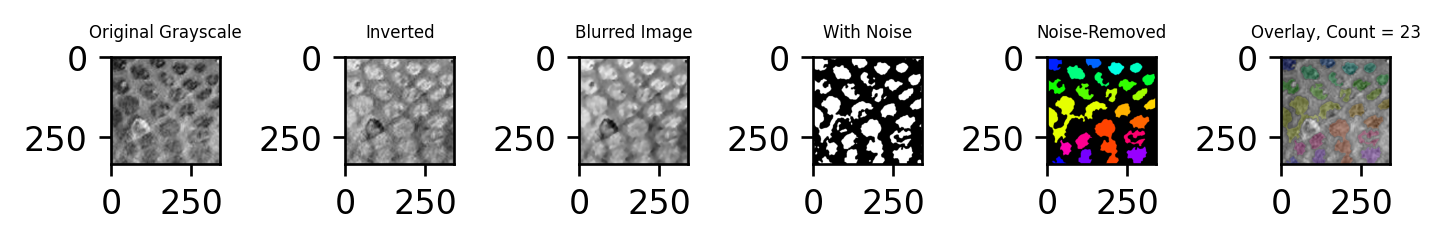

Original image data: {'blocksize': 75, 'iterations': 3, 'score': 3.8961387995316543, 'size_var': 0.7473284733905364, 'dist': 7.0449491256727725}
Inverted image data: {'blocksize': 115, 'iterations': 1, 'score': 100, 'size_var': None, 'dist': None}

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117702Ventral-NoFlash-1.png
Final Scale Count: 40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


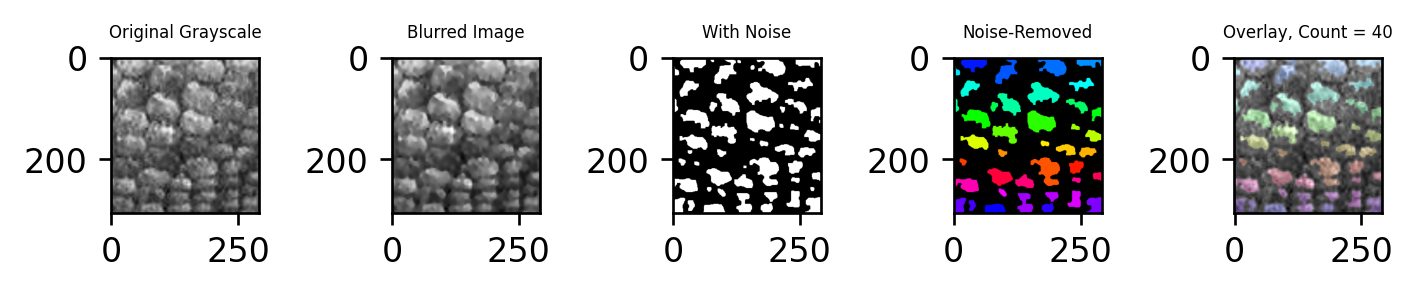

Original image data: {'blocksize': 93, 'iterations': 1, 'score': 5.902687107651644, 'size_var': 0.28943047787258247, 'dist': 11.515943737430707}
Inverted image data: {'blocksize': 93, 'iterations': 1, 'score': 100, 'size_var': None, 'dist': None}
Could not find 1 subimages that pass the quality check.

Tried both original and inverted, but decided to keep original.
Image Name: Guanica_County_images/117702Ventral-NoFlash-4.png
Final Scale Count: 20


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


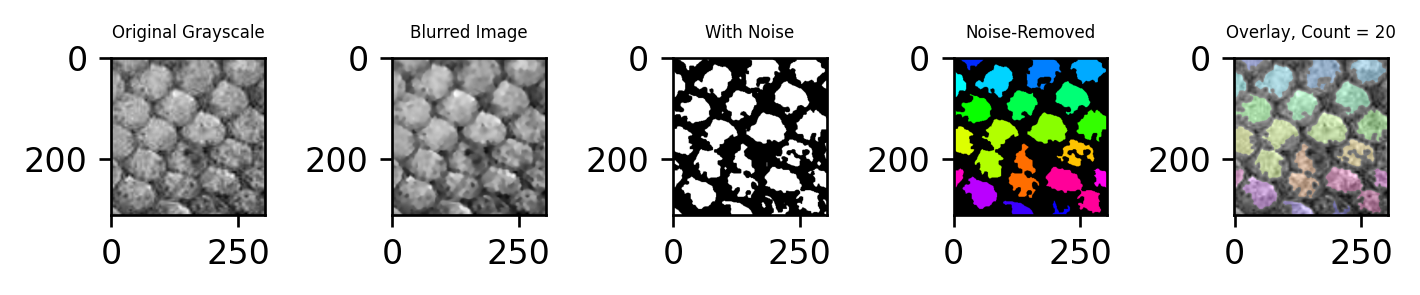

In [893]:
count_scales_directory('Guanica_County_images/')

SUBIMAGE #0:

Original image data: {'blocksize': 31, 'iterations': 2, 'score': 1.129762463057983, 'size_var': 0.38846682757466017, 'dist': 1.8710580985413057}

Original image passed all tests; did not need to check inverted.
Image Name: Large_images/135161_V_large_sample_01_01.png
Final Scale Count: 46


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


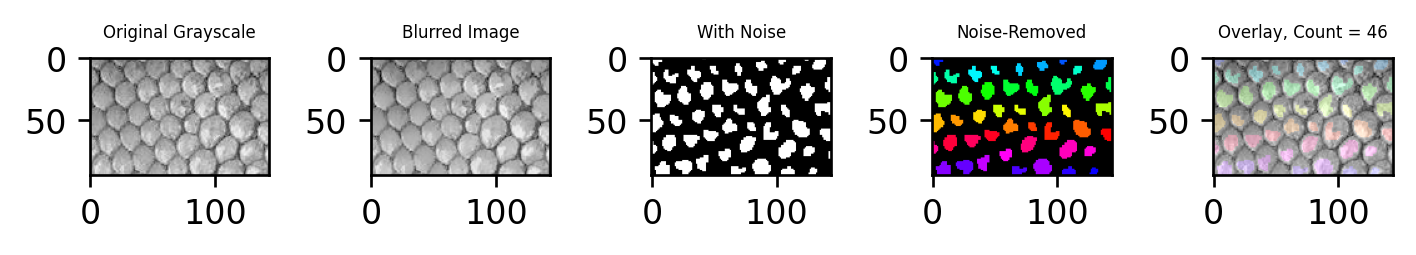

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SUBIMAGE #1:

Original image data: {'blocksize': 47, 'iterations': 3, 'score': 1.5484683500163485, 'size_var': 0.48179278749188215, 'dist': 2.615143912540815}

Original image passed all tests; did not need to check inverted.
Image Name: Large_images/135161_V_large_sample_01_02.png
Final Scale Count: 36


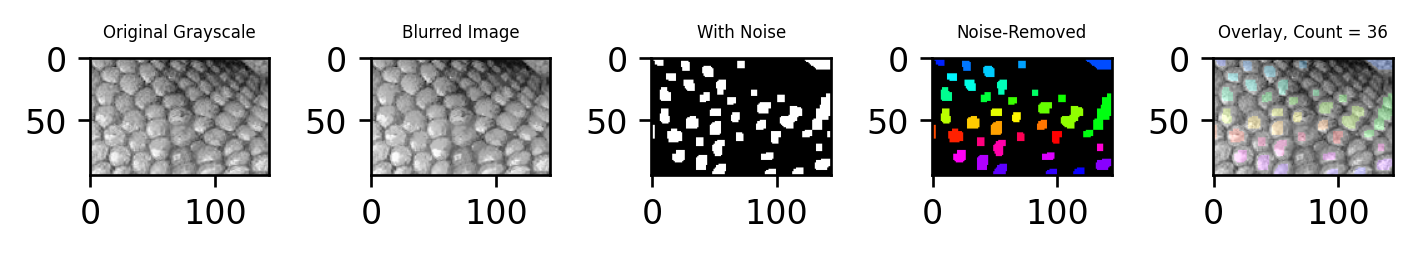

SUBIMAGE #2:

Original image data: {'blocksize': 51, 'iterations': 3, 'score': 3.9795937044343193, 'size_var': 0.8124625103038703, 'dist': 7.146724898564768}
Inverted image data: {'blocksize': 59, 'iterations': 3, 'score': 56.87836386357681, 'size_var': 100, 'dist': 13.756727727153617}

Tried both original and inverted, but decided to keep original.
Image Name: Large_images/135161_V_large_sample_01_03.png
Final Scale Count: 17


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


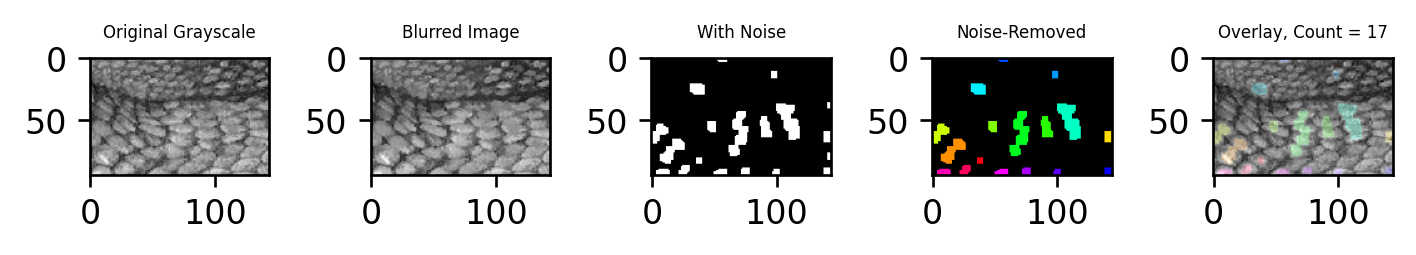

SUBIMAGE #3:

Original image data: {'blocksize': 41, 'iterations': 2, 'score': 1.4141976850397822, 'size_var': 0.5247472850225688, 'dist': 2.3036480850569956}

Original image passed all tests; did not need to check inverted.
Image Name: Large_images/135161_V_large_sample_02_01.png
Final Scale Count: 47


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


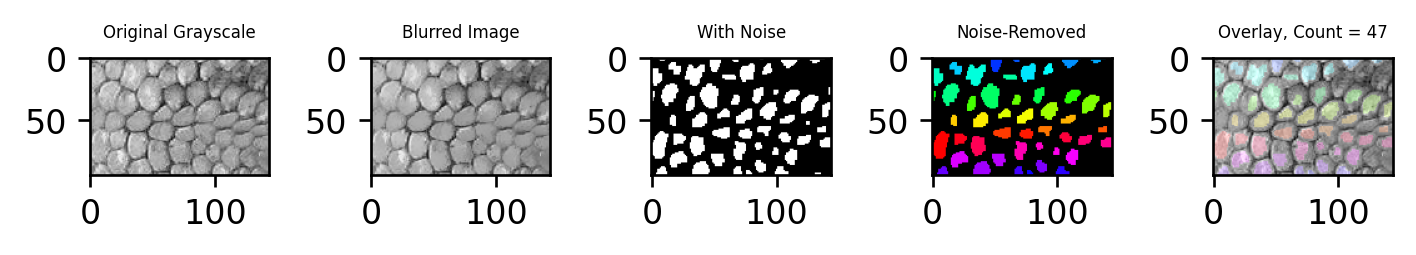

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SUBIMAGE #4:

Original image data: {'blocksize': 33, 'iterations': 2, 'score': 1.336877654560837, 'size_var': 0.4873080610945595, 'dist': 2.1864472480271147}

Original image passed all tests; did not need to check inverted.
Image Name: Large_images/135161_V_large_sample_02_02.png
Final Scale Count: 51


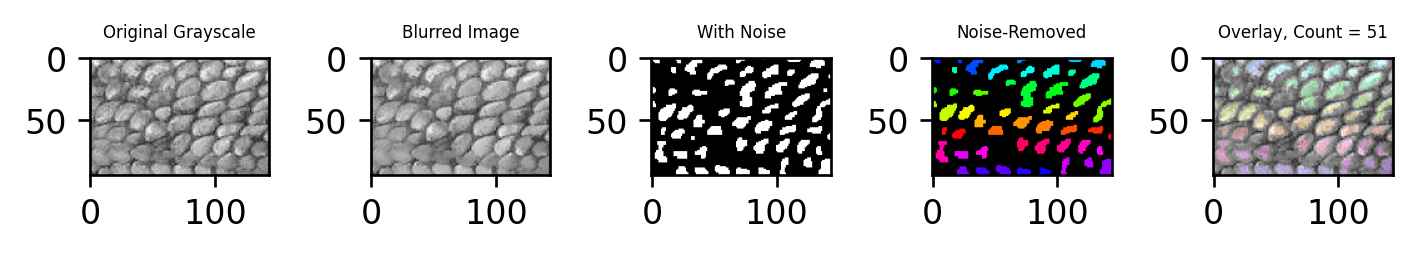

SUBIMAGE #5:

Original image data: {'blocksize': 43, 'iterations': 2, 'score': 1.4105629929048262, 'size_var': 0.7835453896692667, 'dist': 2.0375805961403857}

Original image passed all tests; did not need to check inverted.
Image Name: Large_images/135161_V_large_sample_02_03.png
Final Scale Count: 51


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


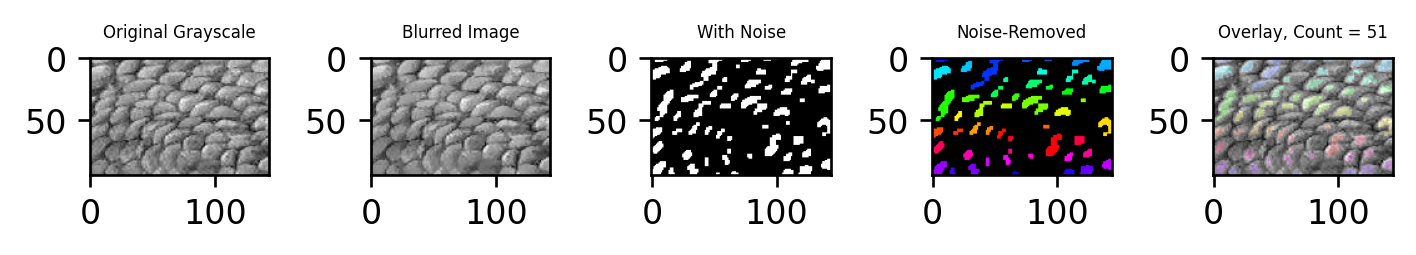

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SUBIMAGE #6:

Original image data: {'blocksize': 51, 'iterations': 3, 'score': 1.6459825459245196, 'size_var': 0.5008273001986238, 'dist': 2.7911377916504154}

Original image passed all tests; did not need to check inverted.
Image Name: Large_images/135161_V_large_sample_03_01.png
Final Scale Count: 36


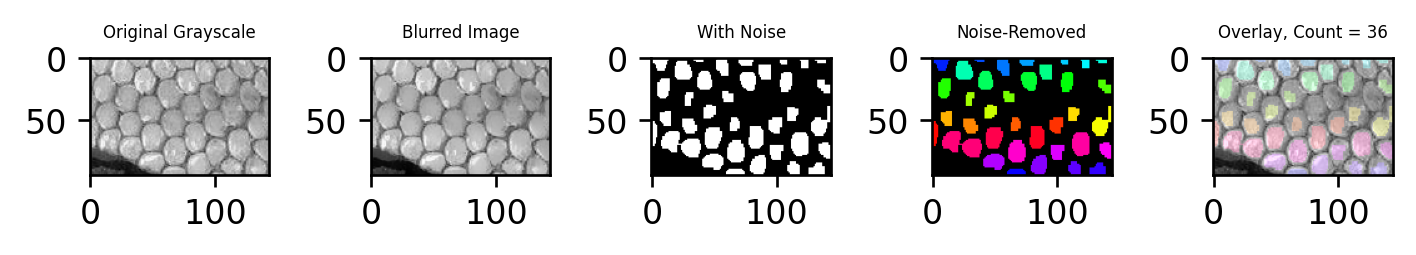

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SUBIMAGE #7:

Original image data: {'blocksize': 37, 'iterations': 2, 'score': 1.7053501852376536, 'size_var': 0.5764974339132576, 'dist': 2.8342029365620496}

Original image passed all tests; did not need to check inverted.
Image Name: Large_images/135161_V_large_sample_03_02.png
Final Scale Count: 40


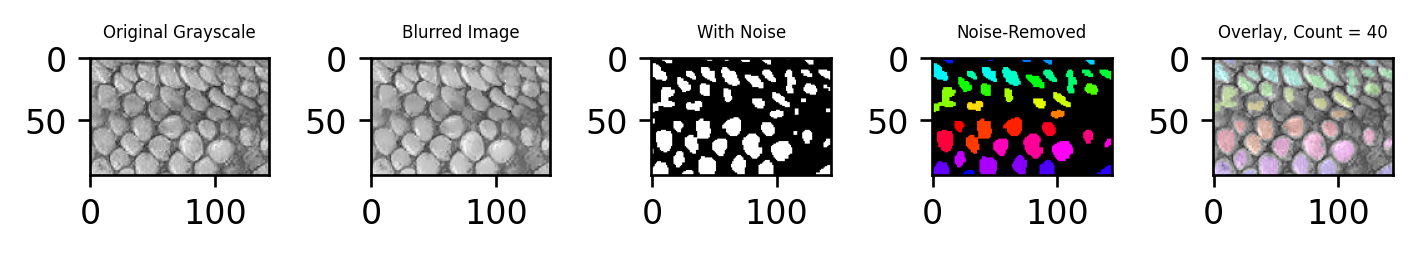

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


SUBIMAGE #8:

Original image data: {'blocksize': 29, 'iterations': 1, 'score': 1.4400801160772772, 'size_var': 0.7858557297890156, 'dist': 2.0943045023655387}

Original image passed all tests; did not need to check inverted.
Image Name: Large_images/135161_V_large_sample_03_03.png
Final Scale Count: 53


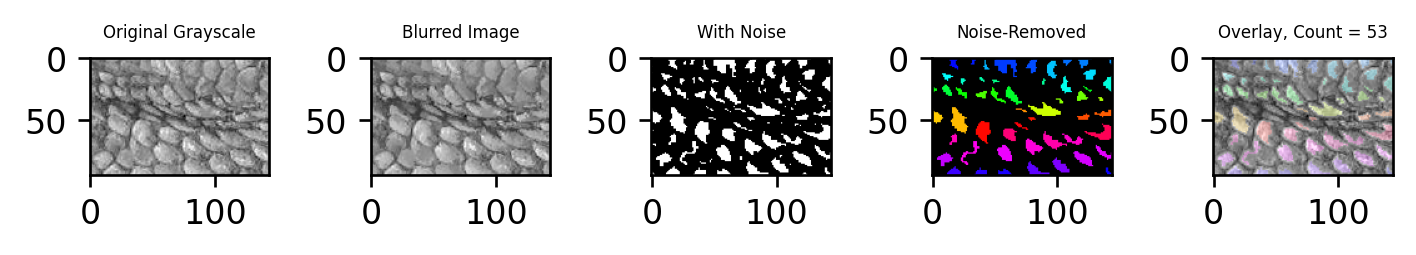

ESTIMATED TOTAL COUNT: 394.6666666666667 SCALES

_______________________________________________

SELECTED SUBIMAGES: [0, 4, 5]


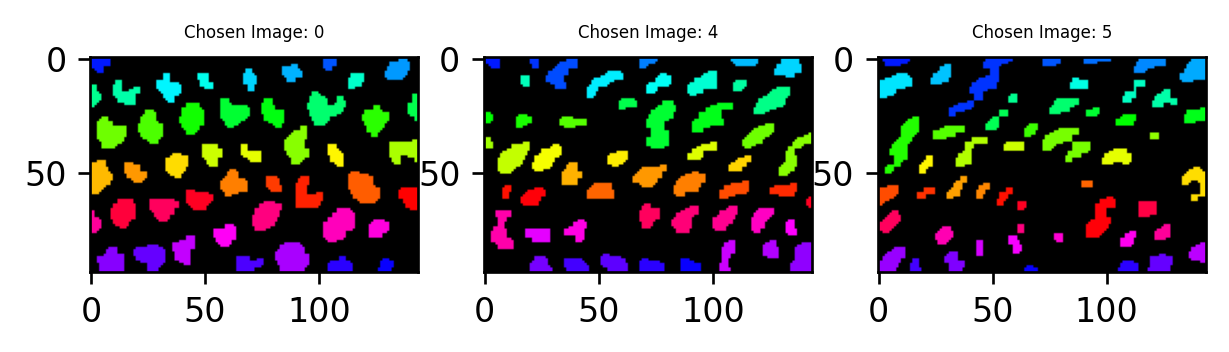

In [894]:
split_count_select('Large_images/135161_V_large_sample.png', 8, 3)